In [5]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.api.types import is_integer_dtype
import seaborn as sns

# hide warning when displaying DataFrames ("RuntimeWarning: invalid value encountered in greater has_large_value")
import warnings
warnings.simplefilter(action="ignore", category=RuntimeWarning)



In [6]:
PATH_TRAIN = Path('train.csv')
PATH_TEST = Path('test.csv')
PATH_ORIGINAL = Path('sample_submission.csv')

In [7]:
df_train = pd.read_csv(PATH_TRAIN).set_index("id")
df_test = pd.read_csv(PATH_TEST).set_index("id")


In [8]:
display(df_train.head())
display(df_test.head())

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
id,,,,,,,,,,,
0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
id,,,,,,,,,,
750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral


# Data Description
## Summary

In [9]:
def display_summary(df):
    df_desc = pd.DataFrame(df.describe(include="all").transpose())
    df_summary = pd.DataFrame({
        'dtype': df.dtypes,
        '#missing': df.isnull().sum().values,
        '%missing': df.isnull().sum().values / len(df),  # 0.20 -> 20%
        '#duplicates': df.duplicated().sum(),
        '#unique': df.nunique().values,
        'min': df_desc['min'].values,
        'max': df_desc['max'].values,
        'avg': df_desc['mean'].values,
        'std dev': df_desc['std'].values,
        'all integer': (df == np.round(df)).all()
    })
    numerical_features = df.select_dtypes('number').columns
    conv_num_cols = ['min', 'max', 'avg', 'std dev']
    df_summary_numerical = df_summary[df_summary.index.isin(numerical_features)].astype({c: 'float64' for c in conv_num_cols})
    df_summary_categorical = df_summary[~df_summary.index.isin(numerical_features)]
    
    display(df_summary_numerical.style.background_gradient())
    display(df_summary_categorical.drop(columns=conv_num_cols+['all integer']).style.background_gradient())
    
display_summary(df_train)

,dtype,#missing,%missing,#duplicates,#unique,min,max,avg,std dev,all integer
Episode_Length_minutes,float64,87093,0.116124,0,12268,0.000000,325.240000,64.504738,32.969603,False
Host_Popularity_percentage,float64,0,0.000000,0,8038,1.300000,119.460000,59.859901,22.873098,False
Guest_Popularity_percentage,float64,146030,0.194707,0,10019,0.000000,119.910000,52.236449,28.451241,False
Number_of_Ads,float64,1,0.000001,0,12,0.000000,103.910000,1.348855,1.151130,False
Listening_Time_minutes,float64,0,0.000000,0,42807,0.000000,119.970000,45.437406,27.138306,False


,dtype,#missing,%missing,#duplicates,#unique
Podcast_Name,object,0,0.000000,0,48
Episode_Title,object,0,0.000000,0,100
Genre,object,0,0.000000,0,10
Publication_Day,object,0,0.000000,0,7
Publication_Time,object,0,0.000000,0,4
Episode_Sentiment,object,0,0.000000,0,3


In [10]:
display_summary(df_test)

,dtype,#missing,%missing,#duplicates,#unique,min,max,avg,std dev,all integer
Episode_Length_minutes,float64,28736,0.114944,0,11631,2.470000,78486264.000000,419.298741,166854.502468,False
Host_Popularity_percentage,float64,0,0.000000,0,8010,2.490000,117.760000,59.716491,22.880028,False
Guest_Popularity_percentage,float64,48832,0.195328,0,9961,0.000000,116.820000,52.192796,28.445034,False
Number_of_Ads,float64,0,0.000000,0,6,0.000000,2063.000000,1.355852,4.274399,False


,dtype,#missing,%missing,#duplicates,#unique
Podcast_Name,object,0,0.000000,0,48
Episode_Title,object,0,0.000000,0,100
Genre,object,0,0.000000,0,10
Publication_Day,object,0,0.000000,0,7
Publication_Time,object,0,0.000000,0,4
Episode_Sentiment,object,0,0.000000,0,3


Quick Findings
* both numerical and categorical features
* the numerical features are all metric, no integer features (looks suspicious for 'Number_of_Ads' 🔎)
* no data type differences between train and test
* missing values for the same features in train and test (plus one row lacking 'Number_of_Ads' in train only)
* \>11% missing data for 'Episode_Length_minutes' might pose one of the major challenges in this competition 🔎
* no missing targets ('Listening_Time_minutes') in train
* extreme maximum for 'Episode_Length_minutes' in test (unlike train)🔎
* no duplicate rows

## Fixing Extreme Values for 'Episode_Length_minutes' in test¶

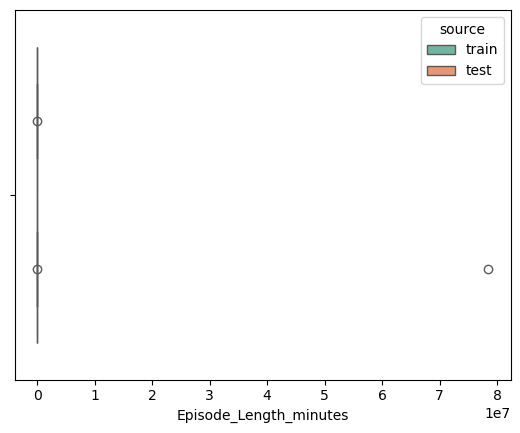

In [11]:
sns.boxplot(data=pd.concat([df_train.assign(source='train'), df_test.assign(source='test')]),
            x='Episode_Length_minutes', 
            hue='source', 
            palette="Set2")
plt.show()

In [12]:
print(f"{df_train['Episode_Length_minutes'].mean()=}")
print(f"{df_test['Episode_Length_minutes'].mean()=}")
print(f"{df_train['Episode_Length_minutes'].median()=}")
print(f"{df_test['Episode_Length_minutes'].median()=}")
print(f"{df_train['Episode_Length_minutes'].max()=}")
print(f"{df_test['Episode_Length_minutes'].max()=}")
print(f"{df_train['Episode_Length_minutes'].max()=}")
print(f"{df_test['Episode_Length_minutes'].max()=}")

print(f"{(df_test['Episode_Length_minutes'] > 325).sum()=}")

df_train['Episode_Length_minutes'].mean()=64.50473835100327
df_test['Episode_Length_minutes'].mean()=419.2987410215604
df_train['Episode_Length_minutes'].median()=63.84
df_test['Episode_Length_minutes'].median()=63.97
df_train['Episode_Length_minutes'].max()=325.24
df_test['Episode_Length_minutes'].max()=78486264.0
df_train['Episode_Length_minutes'].max()=325.24
df_test['Episode_Length_minutes'].max()=78486264.0
(df_test['Episode_Length_minutes'] > 325).sum()=2


In [13]:
df_test[df_test['Episode_Length_minutes'] > 325]

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
id,,,,,,,,,,
804434,Current Affairs,Episode 36,7575.0,News,89.54,Saturday,Night,NaN,2.0,Negative
806597,Market Masters,Episode 23,78486264.0,Business,55.45,Monday,Evening,48.5,0.0,Positive


* For the sake of simplicity and since it's only two rows, we will simply cut the outliers. This facilitates meaningful visualizations.
* However, we need to find a solution when implementing our models.

In [14]:
df_test.loc[df_test['Episode_Length_minutes'] > 325, 'Episode_Length_minutes'] = 325

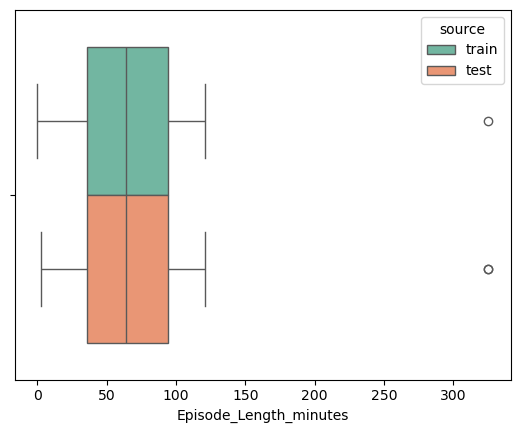

In [15]:
sns.boxplot(data=pd.concat([df_train.assign(source='train'), df_test.assign(source='test')]),
            x='Episode_Length_minutes', 
            hue='source', 
            palette="Set2")
plt.show()

## Fixing 'Number_of_Ads' in train and test

In [16]:
display(df_train['Number_of_Ads'].value_counts(dropna=False))

Number_of_Ads
0.00      217592
1.00      214069
3.00      160173
2.00      158156
103.25         2
53.37          1
NaN            1
103.91         1
103.00         1
53.42          1
103.75         1
12.00          1
103.88         1
Name: count, dtype: int64

In [17]:
display(df_test['Number_of_Ads'].value_counts(dropna=False))

Number_of_Ads
0.00       72863
1.00       71015
3.00       53556
2.00       52564
89.12          1
2063.00        1
Name: count, dtype: int64

* We'll just cut 'Number_of_Ads' at a maximum of 3.
* Set the one NaN to 3, too.
* Then recast as integer

In [18]:
df_train.loc[df_train['Number_of_Ads'] > 3, 'Number_of_Ads'] = 3
df_test.loc[df_test['Number_of_Ads'] > 3, 'Number_of_Ads'] = 3

df_train['Number_of_Ads'] = df_train['Number_of_Ads'].fillna(3)

df_train['Number_of_Ads'] = df_train['Number_of_Ads'].astype(int)
df_test['Number_of_Ads'] = df_test['Number_of_Ads'].astype(int)

display(df_train['Number_of_Ads'].value_counts(dropna=False))
display(df_test['Number_of_Ads'].value_counts(dropna=False))

Number_of_Ads
0    217592
1    214069
3    160183
2    158156
Name: count, dtype: int64

Number_of_Ads
0    72863
1    71015
3    53558
2    52564
Name: count, dtype: int64

# Univariate Distributions
## Numerical Features

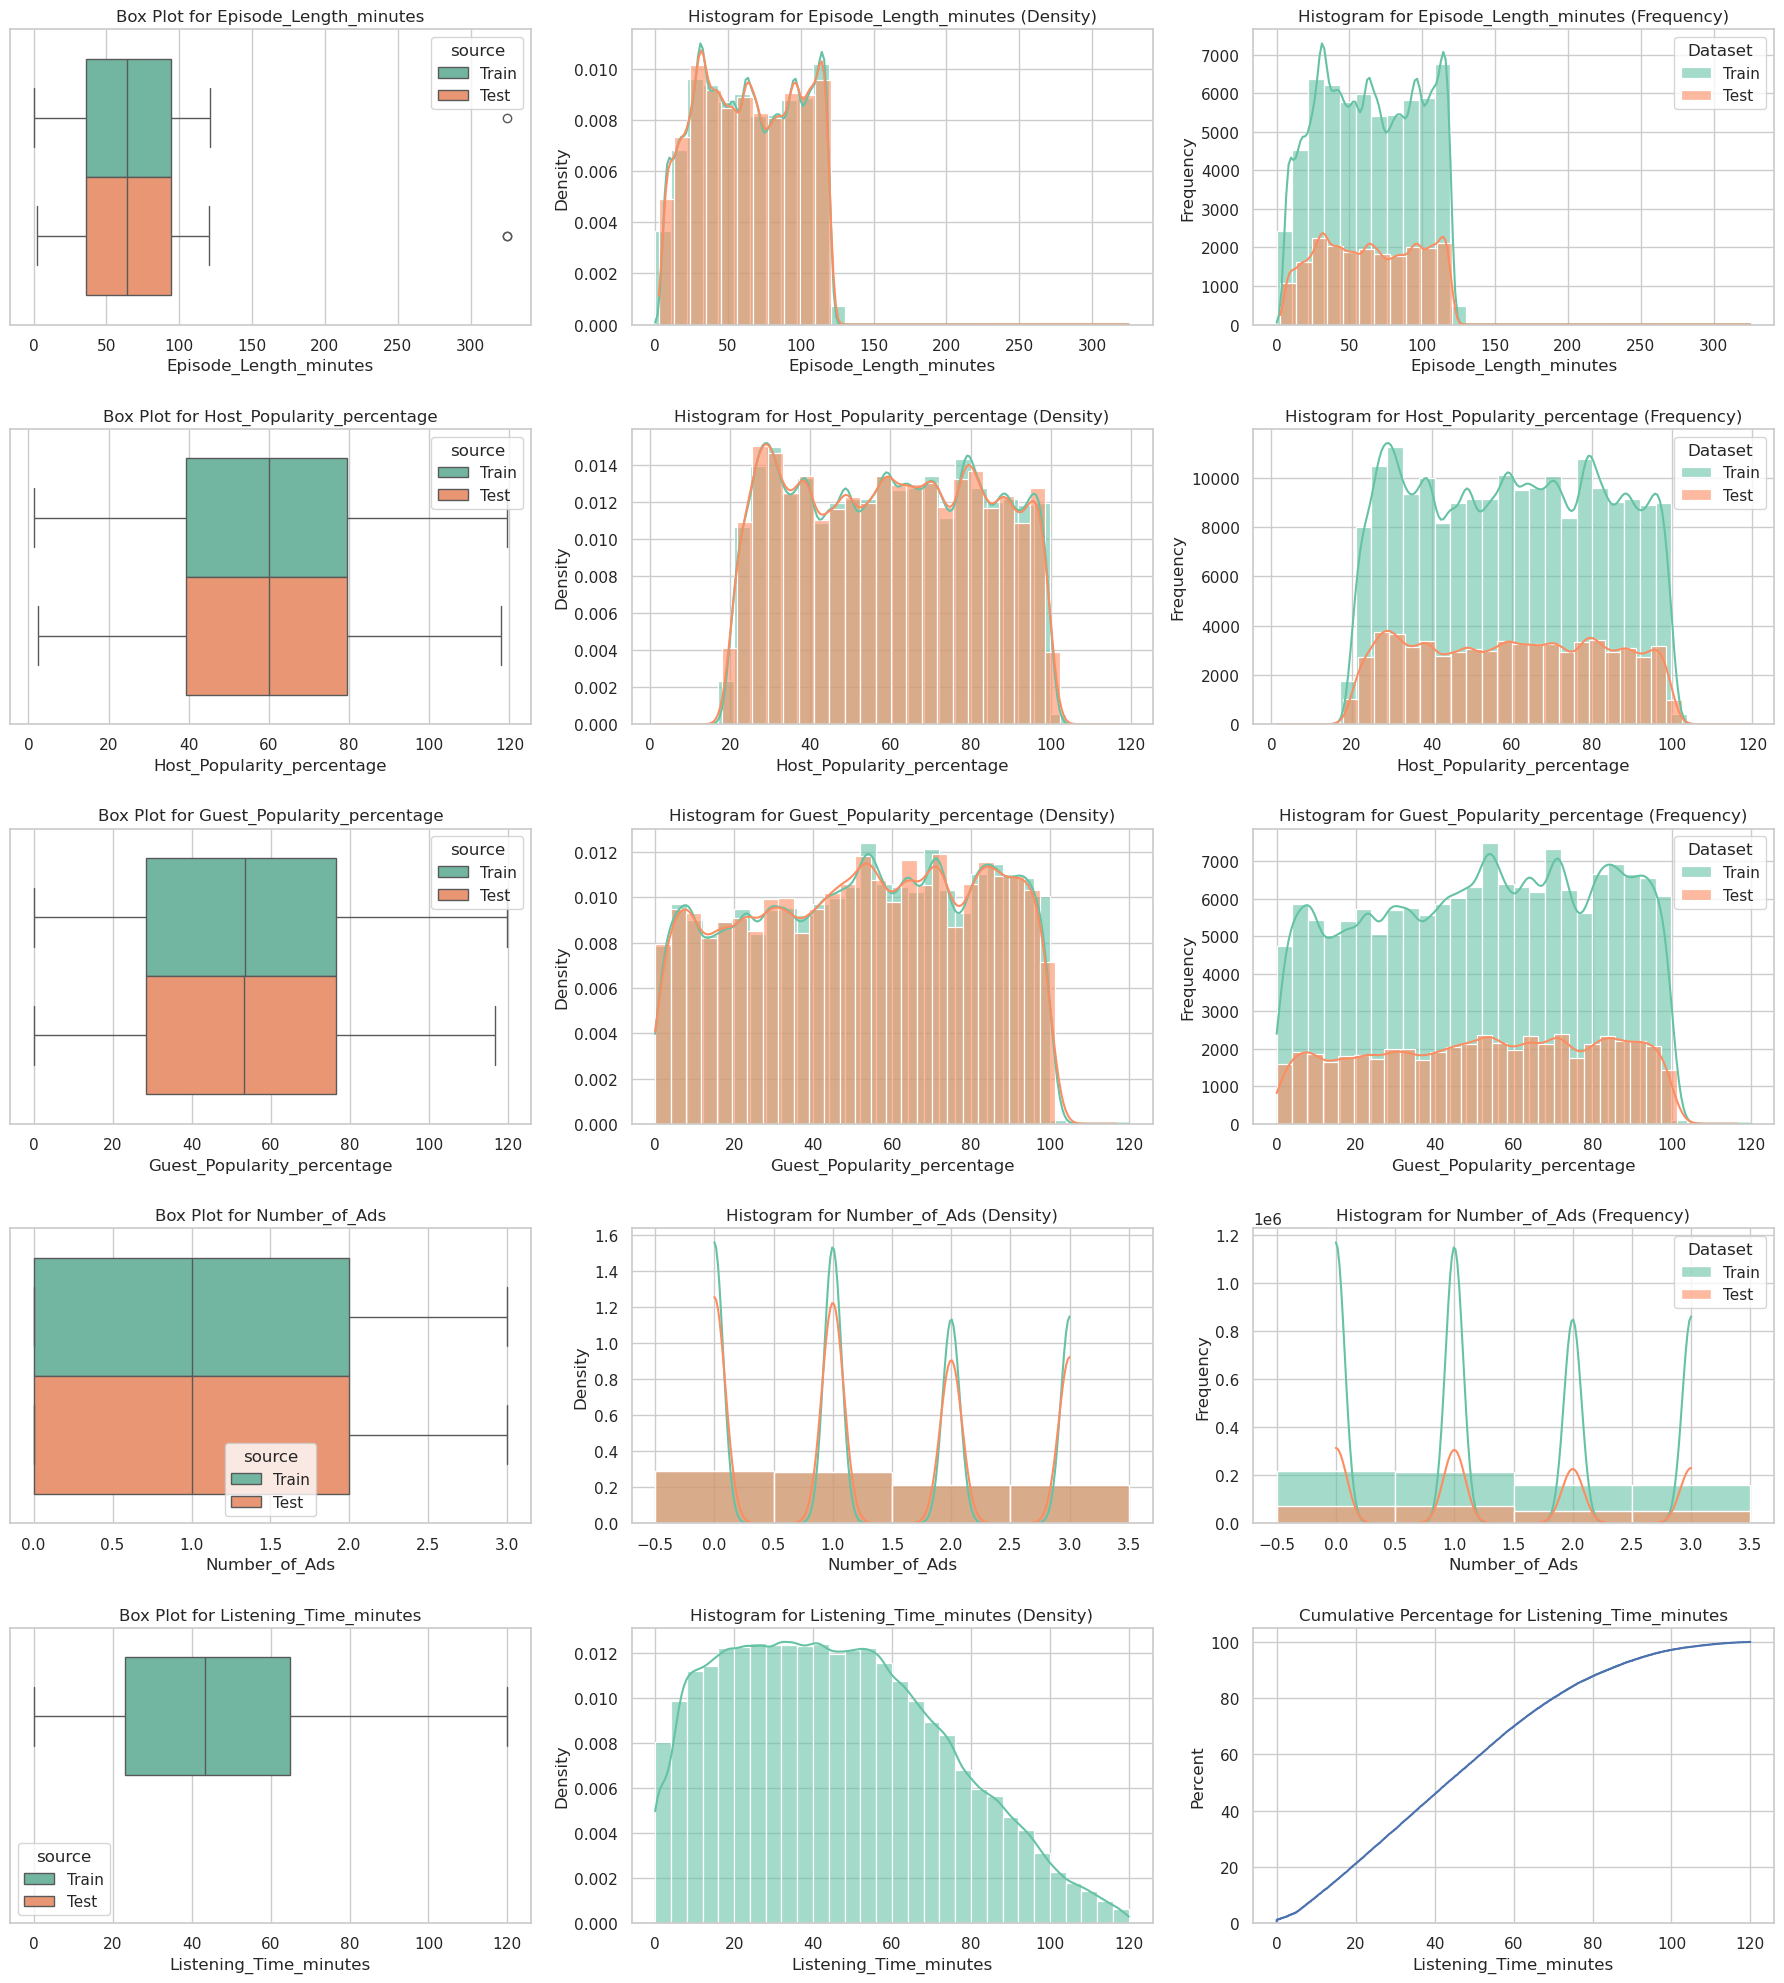

In [19]:
def plot_numerical_feature_distributions_with_box_and_histograms(
    df_features: pd.DataFrame,
    df_features_2: pd.DataFrame,
    labels: tuple[str, str] = ('Train', 'Test'),    
    features: list[str] = None, 
    palette="Set2",
    ):
    features = features or df_features.select_dtypes(include='number').columns
    df_viz = pd.concat([df_features.assign(source=labels[0]), df_features_2.assign(source=labels[1])])
    colors = sns.color_palette(palette, 2).as_hex()
    sns.set(style='whitegrid')
    fig, axes = plt.subplots(len(features), 3, figsize=(18, 4*len(features)))
    for i, feature_name in enumerate(features):
        is_discrete = is_integer_dtype(df_features[feature_name].dtype)
        sns.boxplot(data=df_viz,
                    x=feature_name, hue="source", palette=colors, ax = axes[i][0])
        plt.xlabel(feature_name)
        axes[i][0].set_title(f"Box Plot for {feature_name}")
        sns.histplot(data=df_features, x=feature_name, color=colors[0], kde=True, bins=30, label=labels[0], alpha=0.6, stat='density', discrete=is_discrete, ax = axes[i][1])
        if feature_name in df_features_2:  # target might be missing
            sns.histplot(data=df_features_2, x=feature_name, color=colors[1], kde=True, bins=30, label=labels[1], alpha=0.6, stat='density', discrete=is_discrete, ax = axes[i][1])
        axes[i][1].set_xlabel(feature_name)
        axes[i][1].set_ylabel("Density")
        axes[i][1].set_title(f"Histogram for {feature_name} (Density)")
        if feature_name in df_features_2:
            sns.histplot(data=df_features, x=feature_name, color=colors[0], kde=True, bins=30, label=labels[0], alpha=0.6, stat='frequency', discrete=is_discrete, ax = axes[i][2])
            sns.histplot(df_features_2, x=feature_name, color=colors[1], kde=True, bins=30, label=labels[1], alpha=0.6, stat='frequency', discrete=is_discrete, ax = axes[i][2])
            axes[i][2].set_ylabel("Frequency")
            axes[i][2].set_title(f"Histogram for {feature_name} (Frequency)")
            axes[i][2].legend(title="Dataset")
        else:
            # if we have only one distribution (e.g. train, not test), plot a cumulative percentage curve for first dataset
            sns.ecdfplot(df_features, x=feature_name, ax = axes[i][2], stat="percent")
            axes[i][2].set_title(f"Cumulative Percentage for {feature_name}")
            
        axes[i][2].set_xlabel(feature_name)
    plt.tight_layout()
    plt.show()

plot_numerical_feature_distributions_with_box_and_histograms(df_train, df_test)

Some Notes:
* Some extreme outliers for 'Episode_Length_minutes' had been fixed manually above.
* 'Number_of_Ads' is an integer feature, therefore ignore the strange KDE lines
* train and test distributions seem similar (enough)

## Target Distribution in relation to missing 'Episode_Length_minutes'
'Episode_Length_minutes' is by far the most important feature. Let's look at the target distribution with only missing that feature and with only not-missing that feature.

In [20]:
df_train_only_missing_eplen = df_train.loc[df_train['Episode_Length_minutes'].isna()]
print(f"{len(df_train_only_missing_eplen)=:_}")

df_train_without_missing_eplen = df_train.loc[df_train['Episode_Length_minutes'].notna()]
print(f"{len(df_train_without_missing_eplen)=:_}")

len(df_train_only_missing_eplen)=87_093
len(df_train_without_missing_eplen)=662_907


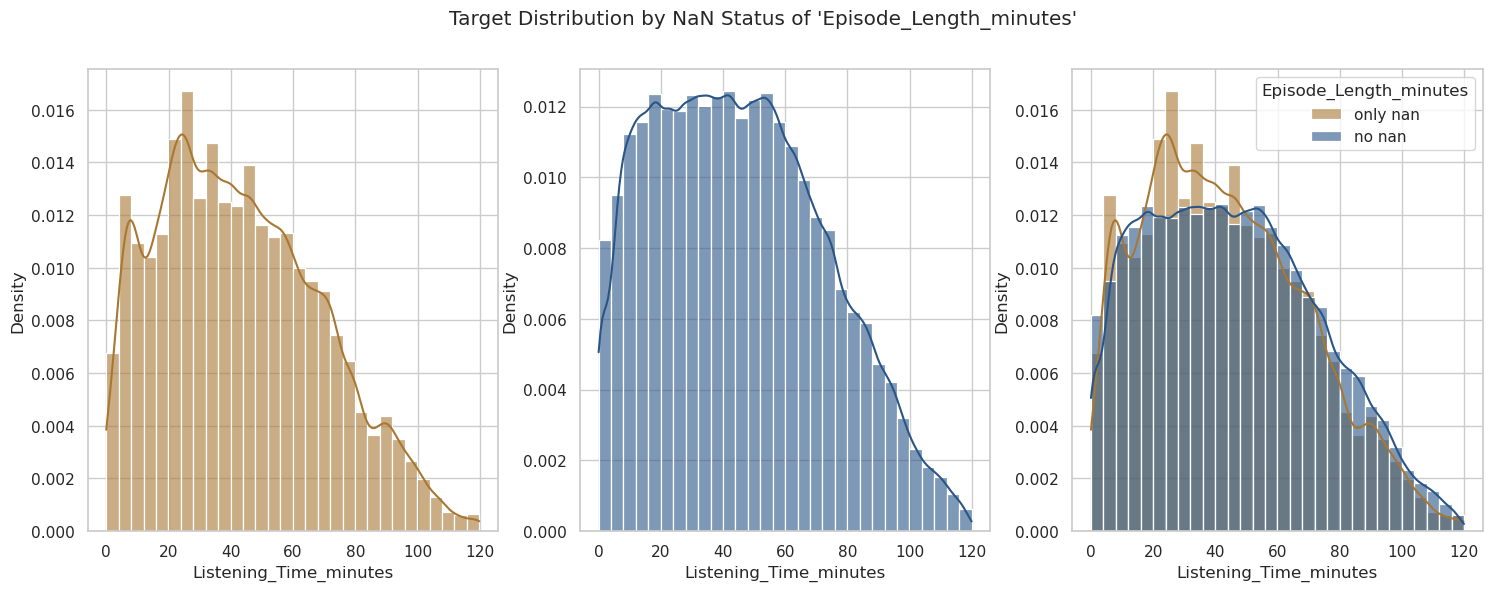

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.histplot(data=df_train_only_missing_eplen, 
             x='Listening_Time_minutes', kde=True, bins=30, alpha=0.6, stat='density', color='#a87732', ax=axes[0])
sns.histplot(data=df_train_without_missing_eplen, 
             x='Listening_Time_minutes', kde=True, bins=30, alpha=0.6, stat='density', color='#295587', ax=axes[1])
sns.histplot(data=df_train_only_missing_eplen, 
             x='Listening_Time_minutes', kde=True, bins=30, alpha=0.6, stat='density', color='#a87732', ax=axes[2], label='only nan')
sns.histplot(data=df_train_without_missing_eplen, 
             x='Listening_Time_minutes', kde=True, bins=30, alpha=0.6, stat='density', color='#295587', ax=axes[2], label='no nan')
axes[2].legend(title="Episode_Length_minutes")

plt.suptitle("Target Distribution by NaN Status of 'Episode_Length_minutes'")
plt.show()

* The distributions are somewhat different but overall similar

## Categorical Features

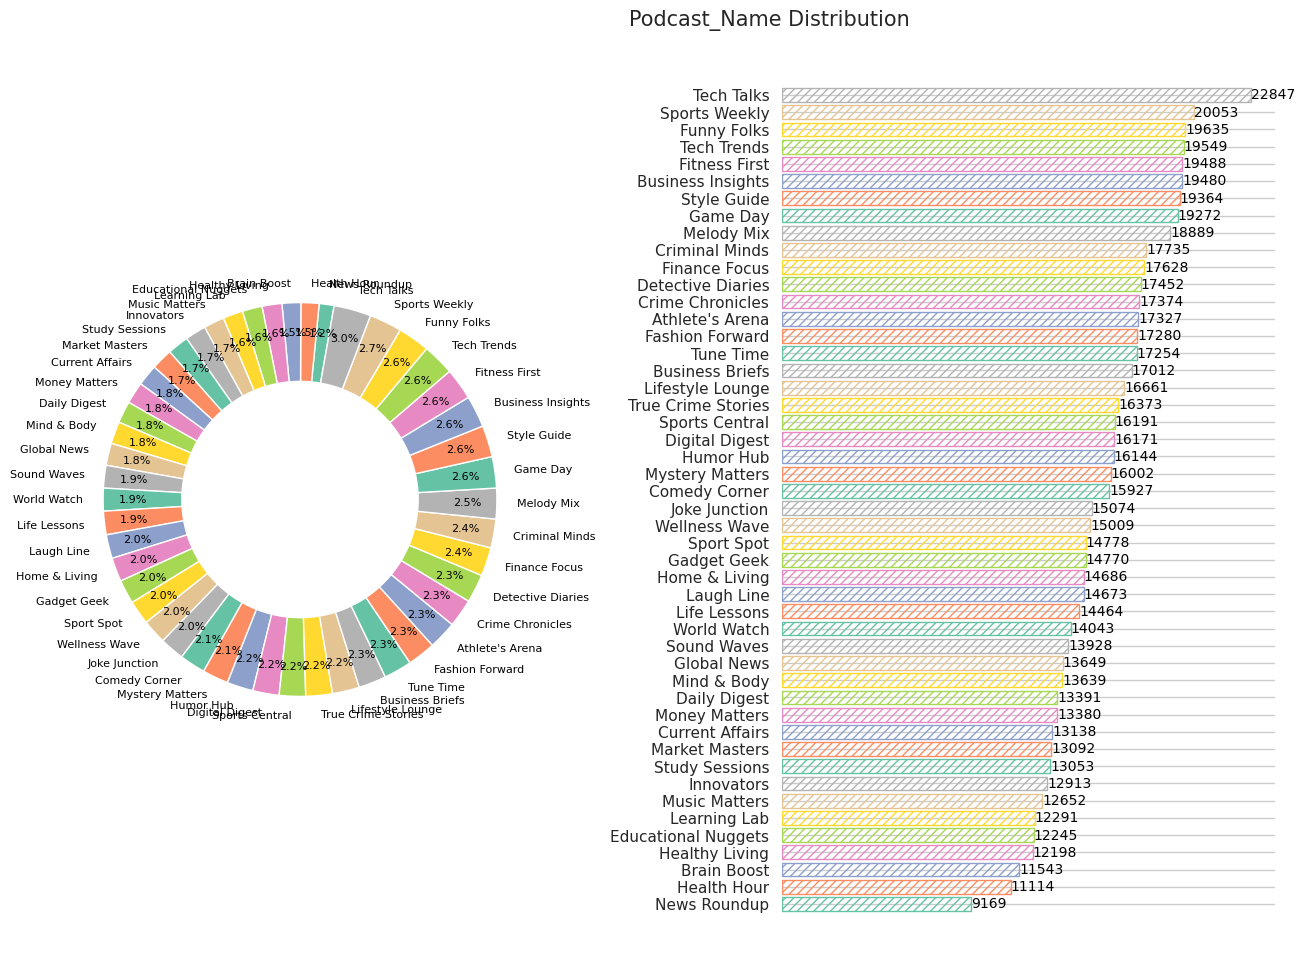

In [22]:
def plot_categorical_feature_distribution(
    ser: pd.Series, 
    palette: str="Set2",
    explode_value=None,
) -> None:
    nunique = ser.nunique()
    fig, axes = plt.subplots(1, 2, figsize=(15 + nunique*0.01, 5 + nunique*0.1))
    axes = axes.flatten()
    value_counts = ser.value_counts(ascending=True)
    labels = value_counts.index.tolist()
    colors = sns.color_palette(palette, len(labels)).as_hex()  # we borrow colors from a seaborn color palette
    # Donut Chart
    explodes=None if explode_value is None else [0.1 if i == explode_value else 0 for i in value_counts.index]
    axes[0].pie(
        value_counts, 
        autopct='%1.1f%%', 
        textprops={'size': 8, 'color': 'black'}, 
        colors=colors,
        wedgeprops=dict(width=0.4),  # donut wedge width
        startangle=80, 
        pctdistance=0.85,  # have percentage displayed within wedge
        explode=explodes,
        labels=labels,
    )
    # Count Plot 
    for i, v in enumerate(value_counts):
        axes[1].barh(y=i, width=v, color='none', edgecolor=colors[i], hatch='////')
        axes[1].text(x=v + 1, y=i, s=str(v), color='black', fontsize=10, va='center')
    axes[1].set_yticks(range(len(labels)))
    axes[1].set_yticklabels(labels)
    sns.despine(left=True, bottom=True)  # remove default spines (borders) from plot
    axes[1].set_xticks([])
    fig.suptitle(f'{ser.name} Distribution', fontsize=15)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

plot_categorical_feature_distribution(ser=df_train['Podcast_Name'])

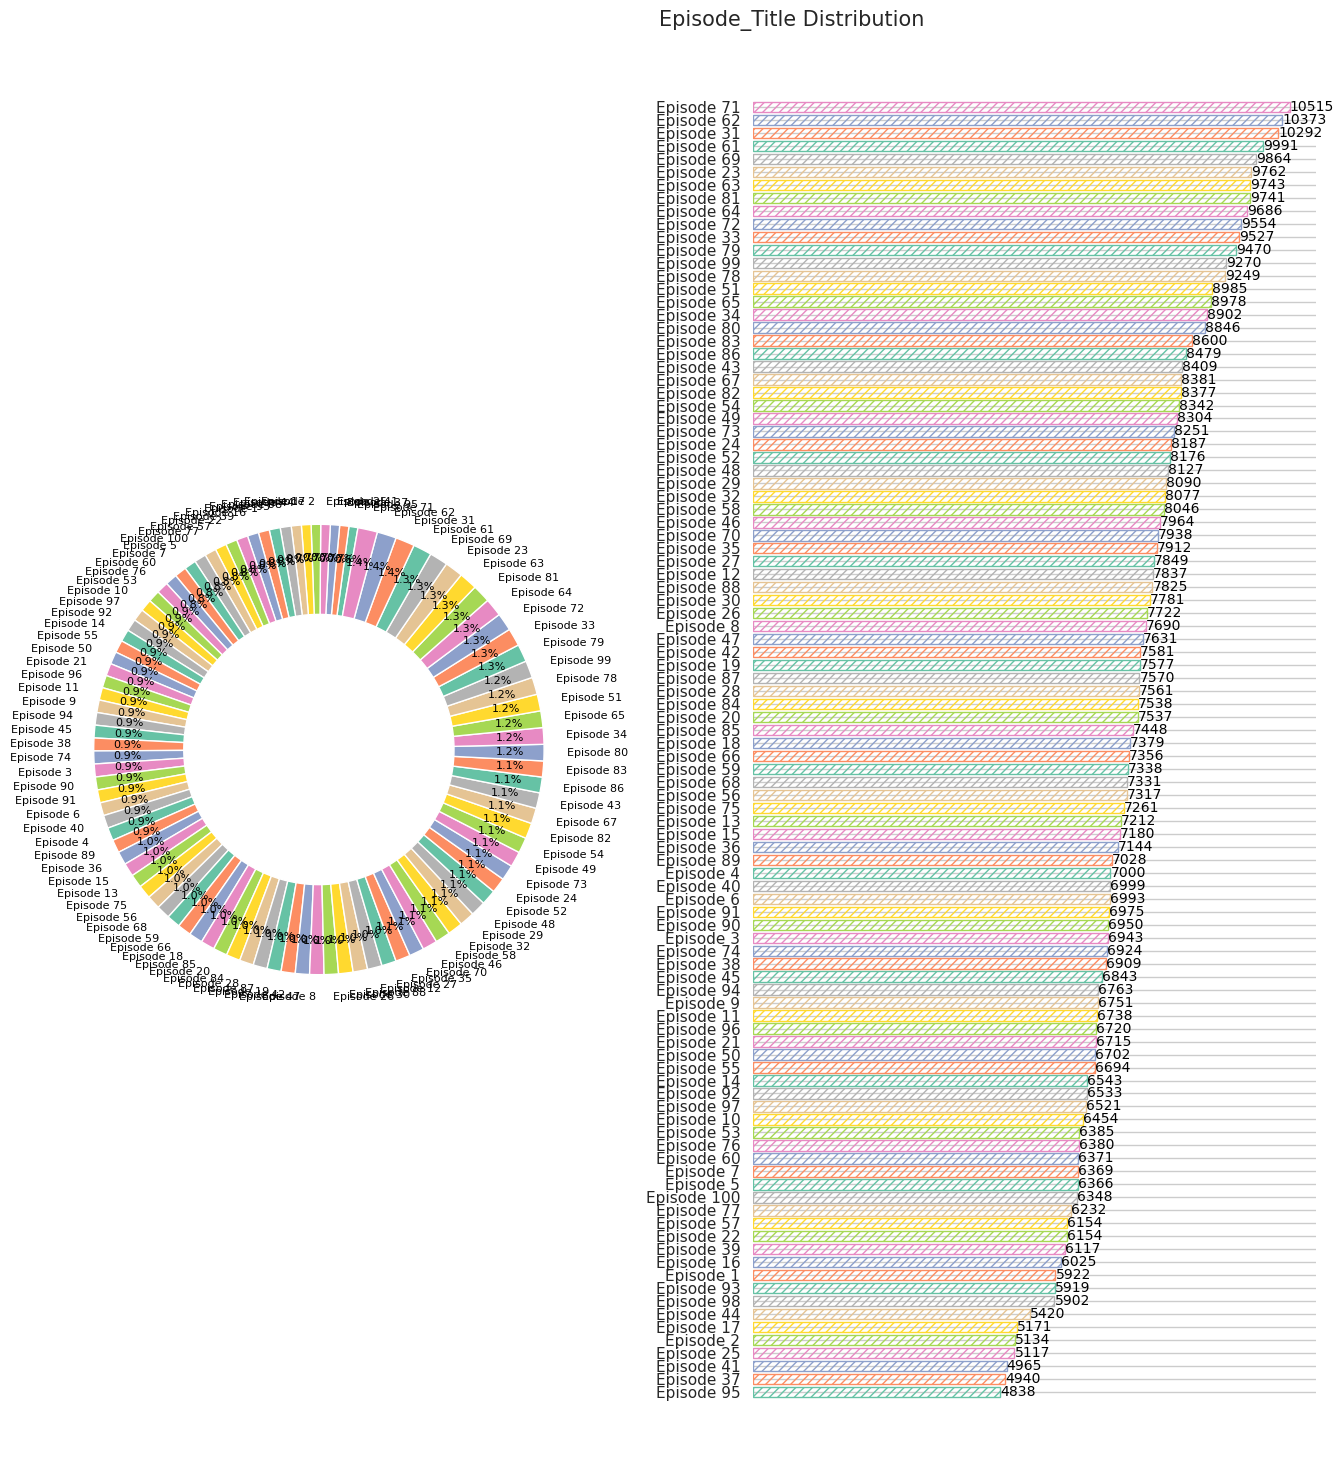

In [23]:
plot_categorical_feature_distribution(ser=df_train['Episode_Title'])

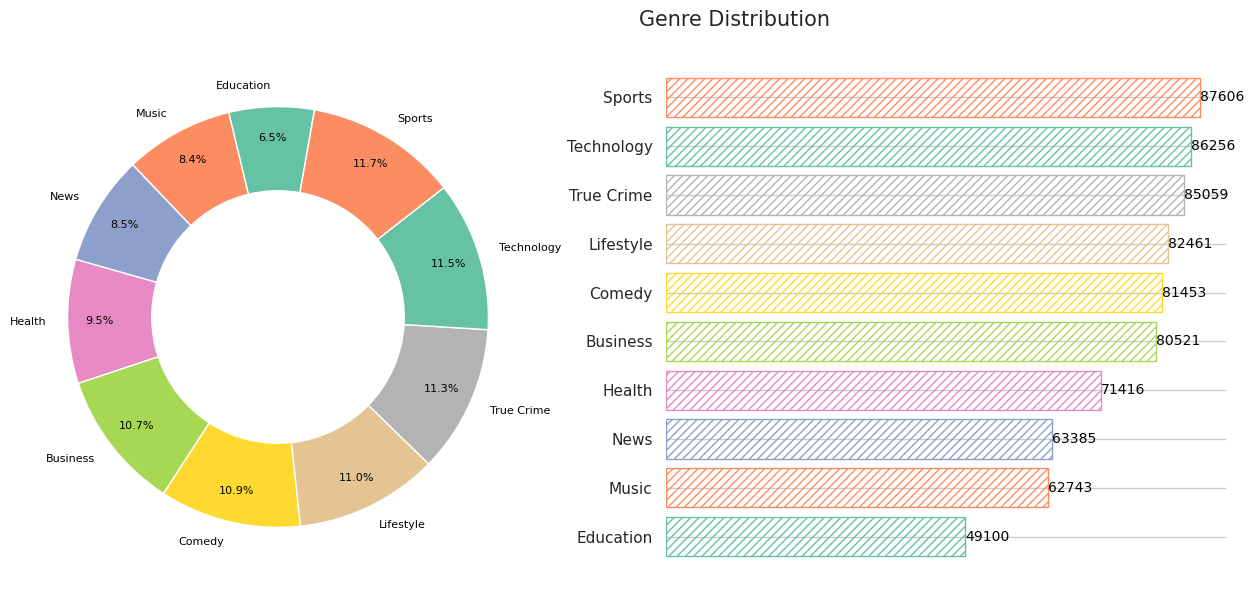

In [24]:
plot_categorical_feature_distribution(ser=df_train['Genre'])

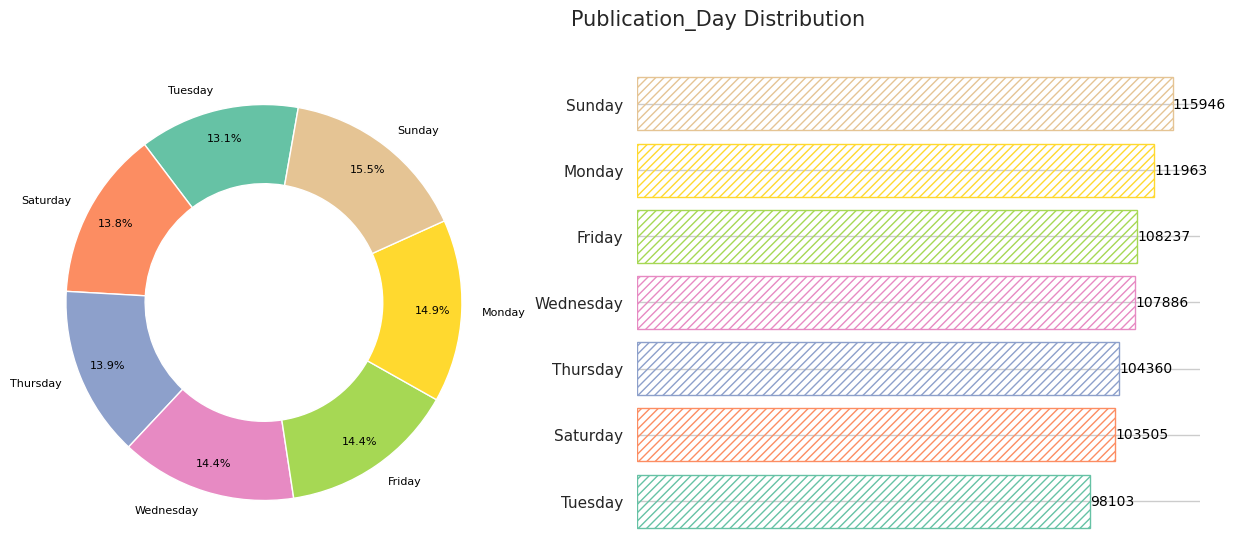

In [25]:
plot_categorical_feature_distribution(ser=df_train['Publication_Day'])

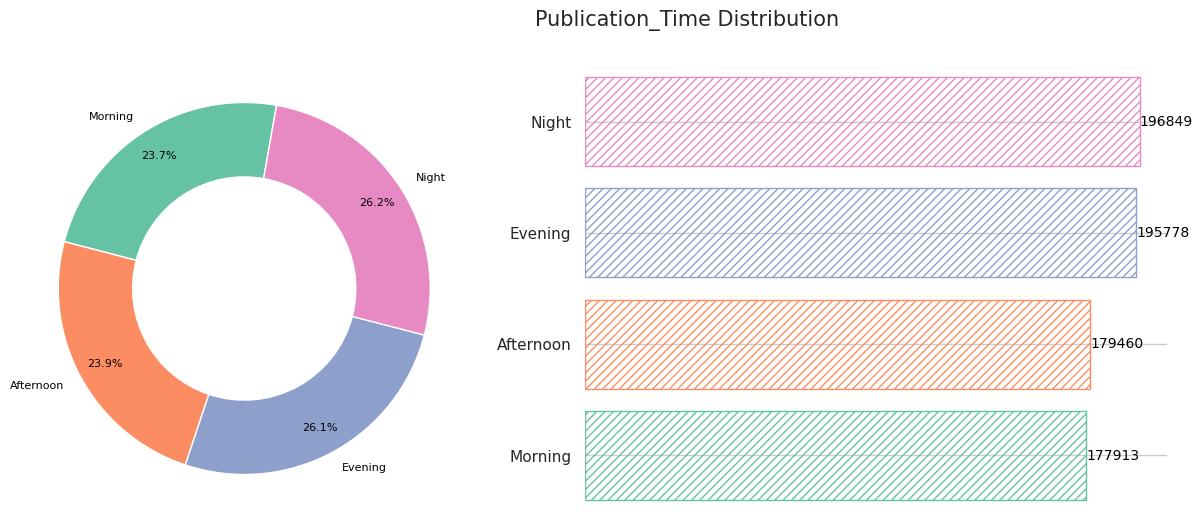

In [26]:
plot_categorical_feature_distribution(ser=df_train['Publication_Time'])

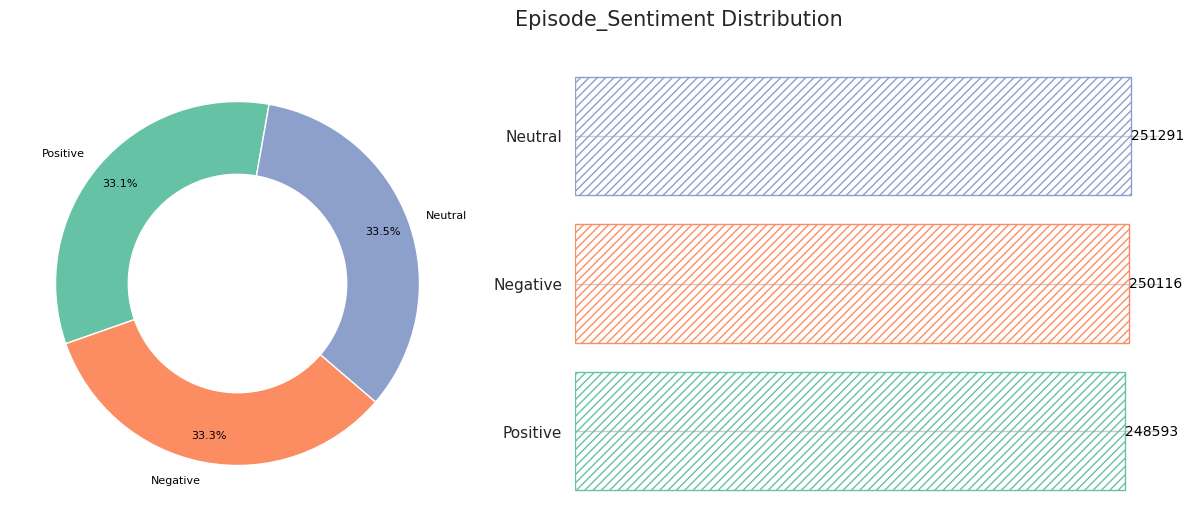

In [27]:
plot_categorical_feature_distribution(ser=df_train['Episode_Sentiment'])

* A typical artificial dataset: very even categories for all features. Don't 

1.   Item daftar
2.   Item daftar

expect that in real life.

# Bivariate Distributions

## Numerical Features and Target
* Note that the following plots discard NaNs! See above for univariate distributions of target with only missing 'Episode_Length_minutes' and without missing 'Episode_Length_minutes'

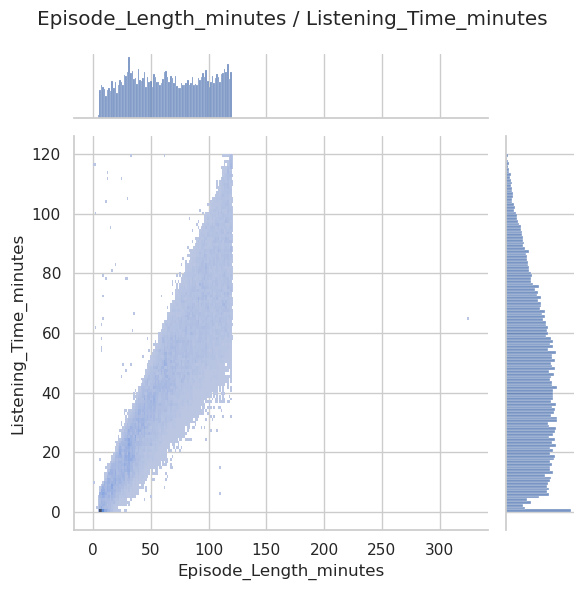

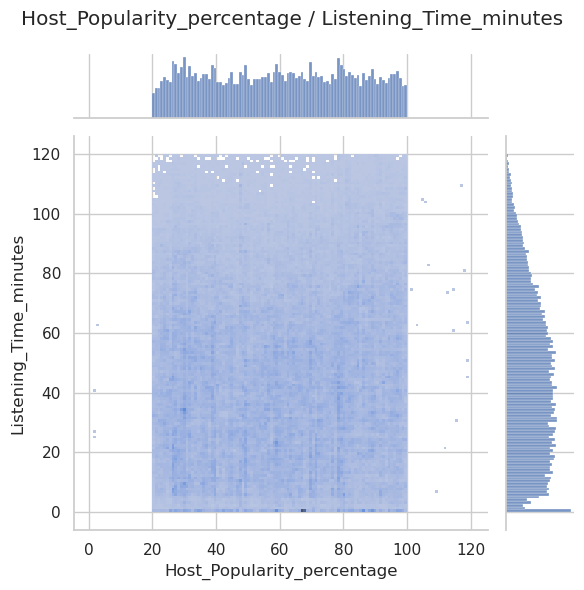

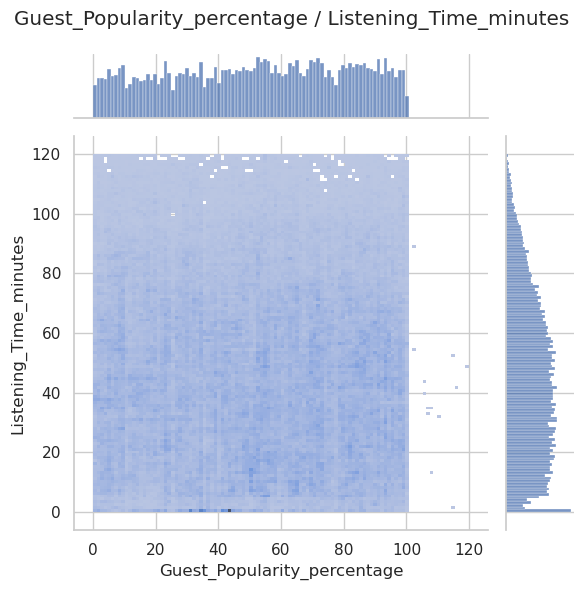

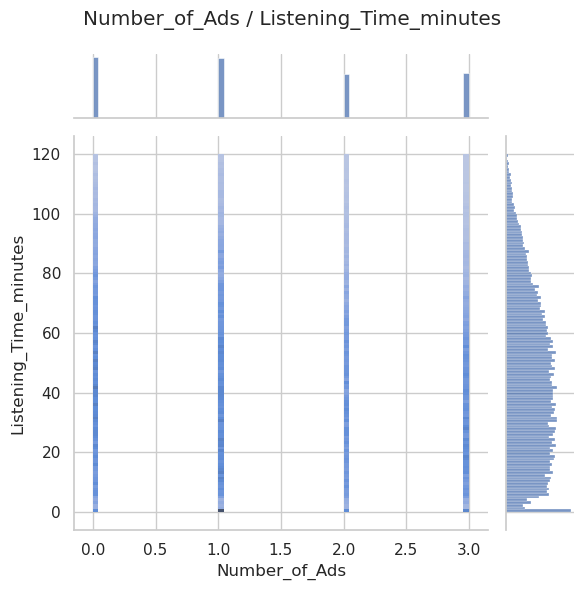

In [28]:
for feature in df_train.drop("Listening_Time_minutes", axis=1).select_dtypes('number').columns:
    p = sns.jointplot(data=df_train, x=feature, y="Listening_Time_minutes", kind="hist")
    p.fig.suptitle(f"{feature} / Listening_Time_minutes")
    p.fig.tight_layout()
    
plt.show()

Findings:
* There's an obvious (and to be expected) trend between 'Listening_Time_minutes' and target
* For the other numerical feature, I don't see an obvious pattern in relation to target
* The artificial data generator may have introduced some extreme outliers. GBDTs won't care. If using linear models or ANN, we will need to fix them.

### Deeper Look: 'Episode_Length_minutes' and Target with Categorical Columns
Idea from @cdeotte (see https://www.kaggle.com/competitions/playground-series-s5e4/discussion/573002 for the original) 

In [29]:
# we need to get rid of that one outlier
df_viz = df_train.copy()
df_viz.loc[df_viz['Episode_Length_minutes'] > 150, 'Episode_Length_minutes'] = 64.5

In [ ]:
g = sns.regplot(df_viz, x='Episode_Length_minutes', y='Listening_Time_minutes', 
            marker="o",  # "o" -> circle
            scatter_kws={'s': 0.1},  # make them smaller
            line_kws={"color": "red"},
           )
g.figure.set_size_inches(18.5, 10.5)

* The correlation between 'Episode_Length_minutes' and our target changes with several categorical features.

In [ ]:
def plot_numerical_vs_target_with_for_multiple_categorical_trendlines(
    df: pd.DataFrame,
    target_column: pd.Series,
    numerical_feature: str,
    categorical_features: list[str],
    palette="deep",  #"tab10"
):
    for categorical_feature in categorical_features:
        sns.lmplot(
            df, x=numerical_feature, y=target_column, 
            scatter_kws={'s': 0.1},
            line_kws={'linewidth': 4},
            hue=categorical_feature,
            height=7,
            aspect=2,
            legend=False,  # dots are barely visible with default legend
            palette=palette,
            )
        plt.legend(fontsize=8, markerscale=40, title=categorical_feature)  # make markers much larger in the legend
        plt.title(f'{target_column} by {numerical_feature} and {categorical_feature}')
        plt.show()

In [ ]:
plot_numerical_vs_target_with_for_multiple_categorical_trendlines(
    df=df_viz,
    target_column='Listening_Time_minutes',
    numerical_feature='Episode_Length_minutes',
    categorical_features=['Genre', 'Publication_Day', 'Publication_Time', 'Number_of_Ads', 'Episode_Sentiment']
)## Numerical 

## Numerical Features (Binned) and Target (Mean)

In [ ]:
def plot_mean_target_by_binned_numerical_feature(
    df_features: pd.DataFrame,
    ser_targets: pd.DataFrame,
    features=None,  # default: all numerical features
    palette="Set2"
):
    colors = sns.color_palette(palette, 2).as_hex() 
    df = pd.concat([df_features, ser_targets], axis=1).copy()
    features = features or df_features.select_dtypes(include='number').columns

    unique_values = ser_targets.unique()
    if len(unique_values) == 2:  # with binary targets, we plot separately for both distributions, otherwise (multi-categories), we don't
        label_0 = f'{ser_targets.name} = {unique_values[0]}'
        label_1 = f'{ser_targets.name} = {unique_values[1]}'
        df_0 = df[df[ser_targets.name] == unique_values[0]]
        df_1 = df[df[ser_targets.name] == unique_values[1]]
    else:
        pass
    
    fig, axes = plt.subplots(len(features), 2, figsize=(12, 4*len(features)))
    for i, col in enumerate(features):
    
        # plot numerical feature distribution
        if len(unique_values) == 2:
            sns.histplot(df_0[col], label=label_0, kde=True, stat="density", alpha=.4, element="step", ax=axes[i][0], color=colors[0])
            sns.histplot(df_1[col], label=label_1, kde=True, stat="density", alpha=.4, element="step", ax=axes[i][0], color=colors[1])
        else:
            sns.histplot(df[col], label=ser_targets.name, kde=True, stat="density", alpha=.4, element="step", ax=axes[i][0], color=colors[0])
        axes[i][0].grid(False)
        axes[i][0].legend()
        axes[i][0].set_title(f"{col}")    
    
        # plot target relationship with binned numerical feature (train only)
        df['bucket'], bin_edges = pd.cut(df[col], bins=10, retbins=True, labels=False)
        bucket_means = df.groupby('bucket')[ser_targets.name].mean()
        if df["bucket"].nunique() < 10:
            # we need to add dummy bucket_means for buckets with no data
            for i_bucket in range(10):
                if i_bucket not in bucket_means.index:
                    bucket_means = pd.concat([bucket_means, pd.Series([0], index=[i_bucket])])
            bucket_means = bucket_means.sort_index()
         
        bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2   
        axes[i][1].plot(bin_midpoints, bucket_means, marker='o', linestyle='-', color=colors[0])
        axes[i][1].set_xlabel(f'{col} (Binned)')
        axes[i][1].set_ylabel(f'Mean {ser_targets.name}')
        axes[i][1].set_title(f'Mean {ser_targets.name} per {col}')
        axes[i][1].set_xticks(bin_midpoints, labels=[round(r, 1) for r in bin_midpoints], rotation=45)
    
    fig.tight_layout() 
    plt.show()

In [ ]:
plot_mean_target_by_binned_numerical_feature(
    df_features=df_train.drop(columns='Listening_Time_minutes'),
    ser_targets=df_train['Listening_Time_minutes'],
    # features=['Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads'],
    palette="tab10",
)

* Episode_Length_minutes: we have a very clear linear relationship to the target; ignore everything beyond the fourth bin (outliers)
* Host_Popularity_percentage and Guest_Popularity_percentage: unclear relationship but high/low target for high feature values
* Number_of_Ads: clear linear relationship to the target; ignore the zero bins (it's actually an integer feature)

## Numerical Features and Alternative Target
Instead of 'Listening_Time_minutes' as a target, we can compute the quota of 'Listening_Time_minutes' and 'Episode_Length_minutes' as an alternative target.

In [ ]:
df_train_alt = df_train.copy()
df_train_alt['Listening_Time_Quota'] = df_train_alt['Listening_Time_minutes'] / df_train_alt['Episode_Length_minutes']

print(f'{df_train_alt.shape=}')

We need to fix some inconsistencies. Unfortunately, a lot of data gets lost on the way. For visualization, we just drop everything that makes no sense. For modeling, we might need another approach.

In [ ]:
print(f"{(df_train_alt['Listening_Time_Quota'] > 1).sum()=:_}")

df_train_alt.drop((df_train_alt.loc[df_train_alt['Listening_Time_Quota'] > 1]).index, inplace=True)
print(f"{(df_train_alt['Listening_Time_Quota'] > 1).sum()=:_}")

print(f'{df_train_alt.shape=}')

In [ ]:
for feature in df_train.select_dtypes('number').columns:
    p = sns.jointplot(data=df_train_alt, x=feature, y="Listening_Time_Quota", kind="hist")
    p.fig.suptitle(f"{feature} / Listening_Time_Quota")
    p.fig.tight_layout()
    
plt.show()

* The first figure shows: The higher the 'Episode_Length_minutes', the higher the alternative target ('Listening_Time_Quota')
* Let's look at two thresholds: episodes <= 20 min and episodes >= 100 min

In [ ]:
print(f"{df_train_alt.loc[df_train_alt['Episode_Length_minutes'] <= 20, 'Listening_Time_Quota'].mean()=}")
print(f"{df_train_alt.loc[df_train_alt['Episode_Length_minutes'] <= 20, 'Listening_Time_minutes'].mean()=}")

In [ ]:
print(f"{df_train_alt.loc[df_train_alt['Episode_Length_minutes'] >= 100, 'Listening_Time_Quota'].mean()=}")
print(f"{df_train_alt.loc[df_train_alt['Episode_Length_minutes'] >= 100, 'Listening_Time_minutes'].mean()=}")

* Listeners of podcasts with an 'Episode_Length_minutes' of <= 20  minutes listen for an average of 49.7% of their episode's playtime (6.74 minutes)
* Listeners of podcasts with an 'Episode_Length_minutes' of >= 100 minutes listen for an average of 72.8% of their episode's playtime (80.59 minutes)
* Whats far more intriguing is the low amount of outliers (look at the almost straight line)

In [ ]:
(df_train_alt.loc[df_train_alt['Episode_Length_minutes'] >= 100, 'Listening_Time_Quota'] < 0.4).sum() / len(df_train_alt.loc[df_train_alt['Episode_Length_minutes'] >= 100])

In [ ]:
(df_train.loc[df_train['Episode_Length_minutes'] >= 100, 'Listening_Time_minutes'] < 43).sum() / len(df_train.loc[df_train['Episode_Length_minutes'] >= 100])

* In only 0.29% of the cases did a listener of an episode with a length of >= 100 minutes listen for less than 40% of the episode length.
* In only 0.25% of the cases did a listener of an episode with a length of >= 100 minutes listen for less than 43 minutes.
* -> Doesn't sound too realistic, but this is an artificial dataset. Or I got something totally wrong.

## Categorical Features and Target
'Number_of_Ads' has only 4 unique values (after fixing) which basically makes it a categorical feature.

In [ ]:
def plot_categorical_vs_target(df: pd.DataFrame, target: str, categorical_feature: str, palette="Set2"):
    fig, axes = plt.subplots(1, 2, figsize=(18, 4))
    sns.histplot(df, x=target, hue=categorical_feature, multiple="stack", palette=palette, ax=axes[0])
    sns.violinplot(data=df, x=target, y=categorical_feature, bw_adjust=.3, cut=0, ax=axes[1])
    plt.show()
    
    sns.displot(df, x=target, col=categorical_feature, stat='density')
    plt.show()

plot_categorical_vs_target(df_train.assign(Number_of_Ads_as_cat=df_train['Number_of_Ads'].astype(str)), target="Listening_Time_minutes", categorical_feature="Number_of_Ads_as_cat")

In [ ]:
plot_categorical_vs_target(df_train, target="Listening_Time_minutes", categorical_feature="Publication_Time")

* at Night we have a significantly lower number of very low targets
* generally similar distributions

In [ ]:
plot_categorical_vs_target(df_train, target="Listening_Time_minutes", categorical_feature="Episode_Sentiment")

* with negative sentiments, we have a significantly higher number of very low targets
* generally similar distributions

In [ ]:
plot_categorical_vs_target(df_train, target="Listening_Time_minutes", categorical_feature="Publication_Day")

* just like the features above, we have similar distributrions but varying figures at very low targets

In [ ]:
plot_categorical_vs_target(df_train, target="Listening_Time_minutes", categorical_feature="Genre")

In [ ]:
sns.catplot(data=df_train, x="Listening_Time_minutes", y="Podcast_Name", kind='violin', bw_adjust=.3, cut=0, height=20)
plt.show()

In [ ]:
with pd.option_context("display.max_rows", 200):
    display(pd.concat([
        df_train.groupby('Episode_Title')['Listening_Time_minutes'].mean().rename('mean'),
        df_train.groupby('Episode_Title')['Listening_Time_minutes'].median().rename('median'),
        df_train.groupby('Episode_Title')['Listening_Time_minutes'].std().rename('std'),
        df_train.groupby('Episode_Title')['Listening_Time_minutes'].min().rename('min'),
        df_train.groupby('Episode_Title')['Listening_Time_minutes'].max().rename('max'),
    ], axis=1).sort_index())

## Categorical Features with Target

In [ ]:
df_train

In [ ]:
weekday_map = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
df_pivot = df_train.pivot_table(index='Publication_Day', columns='Publication_Time', values='Listening_Time_minutes', aggfunc='mean').sort_index(key=lambda x: x.map(weekday_map))
df_pivot = df_pivot[['Morning', 'Afternoon', 'Evening', 'Night']]
sns.heatmap(df_pivot, annot=True, fmt=".1f", cmap="crest")
plt.show()

# Correlation

In [ ]:
def draw_correlation_heatmap(df_features: pd.DataFrame, 
                             absolute=False, 
                             annot=False,  # display correlation values in cells
                             figsize=(7,7),
                             title=None,
                            ) -> None:
    if not title:
        title = 'Pearson Correlation' + (' (absolute)' if absolute else '')
    df_corr = df_features.corr(method='pearson')
    if absolute:
        df_corr = df_corr.abs()
    triangle_mask = np.triu(np.ones_like(df_corr))
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(df_corr, 
                mask=triangle_mask, 
                cmap=sns.color_palette("light:b", as_cmap=True) if absolute else 'RdYlBu_r', 
                cbar=True, 
                linewidth=1, 
                annot=annot, #fmt='.2f',
                ax=ax)
    ax.set_title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

draw_correlation_heatmap(df_features=df_train.select_dtypes('number'),
                         annot=True,
                        )    

# Residual Analysis: Simple GBDT Predictions vs Targets
Let's train a very simple cv model and see how predictions relate to targets.

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [ ]:
%%time
model = lgb.LGBMRegressor(**{"random_state": 42, "verbose": -1})
kf = KFold(n_splits=5, shuffle=True, random_state=42)

X = df_train.drop(columns=['Listening_Time_minutes'])
cat_cols = X.select_dtypes('object').columns
X[cat_cols] = X[cat_cols].astype('category')
y = df_train['Listening_Time_minutes']

y_pred_oof = pd.Series(index=X.index, name='pred')
for idx_train, idx_val in kf.split(X):
    X_train, X_val = X.iloc[idx_train], X.iloc[idx_val]
    y_train, y_val = y.iloc[idx_train], y.iloc[idx_val]
    model.fit(X_train, y_train)
    y_pred_oof.loc[idx_val] = model.predict(X_val)

rmse = mean_squared_error(df_train['Listening_Time_minutes'], y_pred_oof, squared=False)
print(f'{rmse=}')

* Flag whether 'Episode_Length_minutes' is given or NaN
* Plot the OOF Predictions vs. Targets by that flag

In [ ]:
df_viz = pd.concat([df_train['Listening_Time_minutes'], 
                    y_pred_oof, 
                    (y_pred_oof - df_train['Listening_Time_minutes']).rename('res'), 
                    df_train['Episode_Length_minutes'].isna().rename('Episode_Length_minutes_isna')], 
                   axis=1)

In [ ]:
sns.relplot(df_viz, x='Listening_Time_minutes', y='pred', height=10, hue='Episode_Length_minutes_isna')
plt.show()

In [ ]:
sns.relplot(df_viz.iloc[:10000], x='Listening_Time_minutes', y='pred', height=10, hue='res', palette=sns.color_palette("icefire", as_cmap=True))
plt.show()

* The main source of high residuals is a lack of 'Episode_Length_minutes'
* Rows with 'Episode_Length_minutes' as NaN are mostly predicted to have an average target value

In [ ]:
idx_isna = df_train['Episode_Length_minutes'].isna()

rmse_missing_Episode_Length_minutes = mean_squared_error(df_train.loc[idx_isna, 'Listening_Time_minutes'], y_pred_oof.loc[idx_isna], squared=False)
print(f'{rmse_missing_Episode_Length_minutes=}')

rmse_has_Episode_Length_minutes = mean_squared_error(df_train.loc[~idx_isna, 'Listening_Time_minutes'], y_pred_oof.loc[~idx_isna], squared=False)
print(f'{rmse_has_Episode_Length_minutes=}')

* The score is far better for those records with 'Listening_Time_minutes' available